# PA3 Part 2. Generating Baby Names with a Character-Level Neural Network Language Model [30 Marks]

<center>
    <img src="./assets/bengio-lm.jpeg">
</center>

### Introduction

This scary looking figure comes from a [2003 paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) that uses a Multi-layer Perceptron for language modeling. It shows a neural network that takes as input a sequence of words and outputs a probability distribution over the next word in the sequence.

We will be putting a twist on this: we will instead create a Language Model (LM) that takes as input a sequence of characters and outputs a probability distribution over the next character in the sequence. This will allow us to generate baby names!

After this notebook, you should be able to:

- Understand the basics of character-level language modeling

- Understand how to process textual data for character-level language modeling

- Brag on Twitter about how you created a neural network that generates baby names

### Instructions

- Follow along with the notebook, filling out the necessary code where instructed.

- <span style="color: red;">Read the Submission Instructions and Plagiarism Policy in the attached PDF.</span>

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code.</span> We will be using the `print` statements to grade your assignment.

- <span style="color: red;">You must attempt all parts.</span> Do not assume that because something is for 0 marks, you can leave it - it will definitely be used in later parts.

## Imports

We'll make all our imports here. <span style="color: red;">Do not use any other libraries.</span>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Creating the Dataset [15 Marks]

You will be using a relatively small dataset, consisting of tens of thousands of baby names. Since the text is, well, non-numeric, we will have to numericalize our data in some way.

Since we're working on a character-level language model, we will be creating encodings for each and every character, hence the *vocabulary* is only as large as the English alphabet.

We will need to maintain a record of *indices*: these will help us convert from characters to numbers and vice versa. Note that we will also include a special character `[.]` to denote the end of a name (since it is necessary for the model to be able to predict when to stop throwing out more characters).

In [ ]:
# Read in the data
with open("names.txt") as f:
    words = f.read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
# Build the vocab and the mappings (5 marks)

chars = set(''.join(words)) # set of all characters in the corpus
chars = sorted(list(chars)) # sorted list of all characters

# TODO: Create a dictionary of char to index and index to char
# Note that . is a special character that should be assigned index 0
# The characters should start from 1
stoi = dict()
itos = dict()
for i,c in enumerate(chars,1):
    stoi[c] = i
    itos[i] = c

stoi['.'] = 0 # special character for EOS or SOS
itos[0] = '.'

print("stoi:",stoi)
itos

stoi: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

Our dataset will be set up in the following way:

- The input to the model will be a fixed-length sequence of characters, that we represent as integers for now. We usually call this the **context vector**.

- The ground truth will be the next character in the sequence, also represented as an integer.

For example, take the name `olivia`. If we have the context length (`ctx_len`) equal $3$, then we can create multiple samples from this name:
- `..o` $\rightarrow$ `l`
- `.ol` $\rightarrow$ `i`
- `oli` $\rightarrow$ `v`
- `liv` $\rightarrow$ `i`
- `ivi` $\rightarrow$ `a`
- `via` $\rightarrow$ `.`

In [ ]:
# Create the actual dataset (10 marks)
ctx_len = 3
X, Y = [], []
# Loop through each of the words
for word in words:

    # TODO: Create an vector of zeros of length ctx_len
    ctx = [0]*ctx_len

    word = word + '.' # add a . at the end of the word

    # Loop through each character in the word
    for char in word:

        # TODO: Convert the character to an index
        char_idx = stoi[char]

        # TODO: Append the context and the index to the X and Y lists respectively
        X.append(ctx)
        Y.append(char_idx)

        # TODO: Update the context by removing the first character and adding the current character
        ctx = ctx[1:]+[char_idx]

# Convert to tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

print("X",X)

print(X.shape, Y.shape) # should be (228146,3), (228146)

X tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])
torch.Size([228146, 3]) torch.Size([228146])


In [ ]:
# Print out a few examples (with the same logic as before)
for i in range(12):
    ctx_idxs = X[i]; targ_idx = Y[i]
    ctx_chars = [itos[j.item()] for j in ctx_idxs]
    ctx_chars = ''.join(ctx_chars)
    targ_char = itos[targ_idx.item()]

    print(f"{ctx_chars} ---> {targ_char}")

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .


## Creating and Training a Model [10 Marks]

We will be using a simple Multilayer Perceptron to create our language model. The model will take in a sequence of characters and output a probability distribution over the next character in the sequence.

Before moving on, think about *one* thing - why are we using a vector of size `ctx_len` with integers to our model? What does this *really* represent?

Does having a sequence of integers actually show any sort of grammatical information to our model? Is it possible that keeping this type of representation fixed, that we selfishly came up with ourselves, be limiting our model's ability to learn language?

What if we let the model *learn* a representation for this information itself?

This is the special idea behind Embeddings. We will be using an Embedding layer, `nn.Embedding`, to learn a representation for each character in our vocabulary. This will allow our model to learn a representation that is more suited to the task at hand.

You can read more about Embeddings [here](https://en.wikipedia.org/wiki/Word_embedding) for starters, but for now, think of it as a way to *project* some identifier (whether that be an integer or a one-hot vector for a character index), into *some* vector space. This vector space is learned by the model, and is optimized for the task at hand. If we set the size of the embedding to be $d$, then the output of the embedding layer will be a vector of size $d$.

Put simply, for the task at hand, Embeddings let you turn characters into learnable vectors.

In [ ]:
# Create the language model and perform a forward pass (10 marks)
class MLPLM(nn.Module):
    def __init__(self, vocab_size=27, emb_dim=2, ctx_len=3):
        super().__init__()

        # TODO: Create an embedding layer to extract better features (vocab_size -> emb_dim)
        self.embedding = nn.Embedding(vocab_size, emb_dim)

        # TODO: Create a regular neural network (emb_dim*ctx_len -> ... -> vocab_size)
        self.my_nn = nn.Sequential(
            nn.Linear(emb_dim*ctx_len, 128),
            nn.ReLU(),
            nn.Linear(128, 100),
            nn.ReLU(),
            nn.Linear(100, 70),
            nn.ReLU(),
            nn.Linear(70, vocab_size)
        )

    def forward(self, x):

        # TODO: Pass the input through the embedding layer
        x = self.embedding(x)
        # x = self.my_nn(x)

        # TODO: Flatten the input (batch_size, ctx_len, emb_dim) -> (batch_size, ctx_len*emb_dim)
        flattened_input = x.view(x.size(0), -1)

        # TODO: Pass the flattened input through the feedforward network
        return self.my_nn(flattened_input)

model = MLPLM()

# Dummy forward pass
out = model(X)
print(out.shape) # should be (228146, 27)

torch.Size([228146, 27])


X_train: tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [11,  1, 25],
        [ 1, 25, 22],
        [25, 22,  9]])
y_train: tensor([ 5, 13, 13,  ..., 22,  9, 15])
torch.Size([159700, 3]) torch.Size([159700]) torch.Size([68446, 3]) torch.Size([68446])
Epoch 0 | Train loss: 3.2854 | Train Acc: 0.0146 | Val loss: 3.2359 | Val acc: 0.1599
Epoch 1 | Train loss: 3.2171 | Train Acc: 0.1756 | Val loss: 3.1741 | Val acc: 0.1829
Epoch 2 | Train loss: 3.1377 | Train Acc: 0.1969 | Val loss: 3.0931 | Val acc: 0.1888
Epoch 3 | Train loss: 3.0267 | Train Acc: 0.1986 | Val loss: 3.0260 | Val acc: 0.1890
Epoch 4 | Train loss: 2.9138 | Train Acc: 0.1956 | Val loss: 3.0648 | Val acc: 0.1913
Epoch 5 | Train loss: 2.8929 | Train Acc: 0.1998 | Val loss: 3.0866 | Val acc: 0.1573
Epoch 6 | Train loss: 2.8795 | Train Acc: 0.1861 | Val loss: 3.0459 | Val acc: 0.1368
Epoch 7 | Train loss: 2.8324 | Train Acc: 0.1788 | Val loss: 2.9919 | Val acc: 0.1363
Epoch 8 | Train loss:

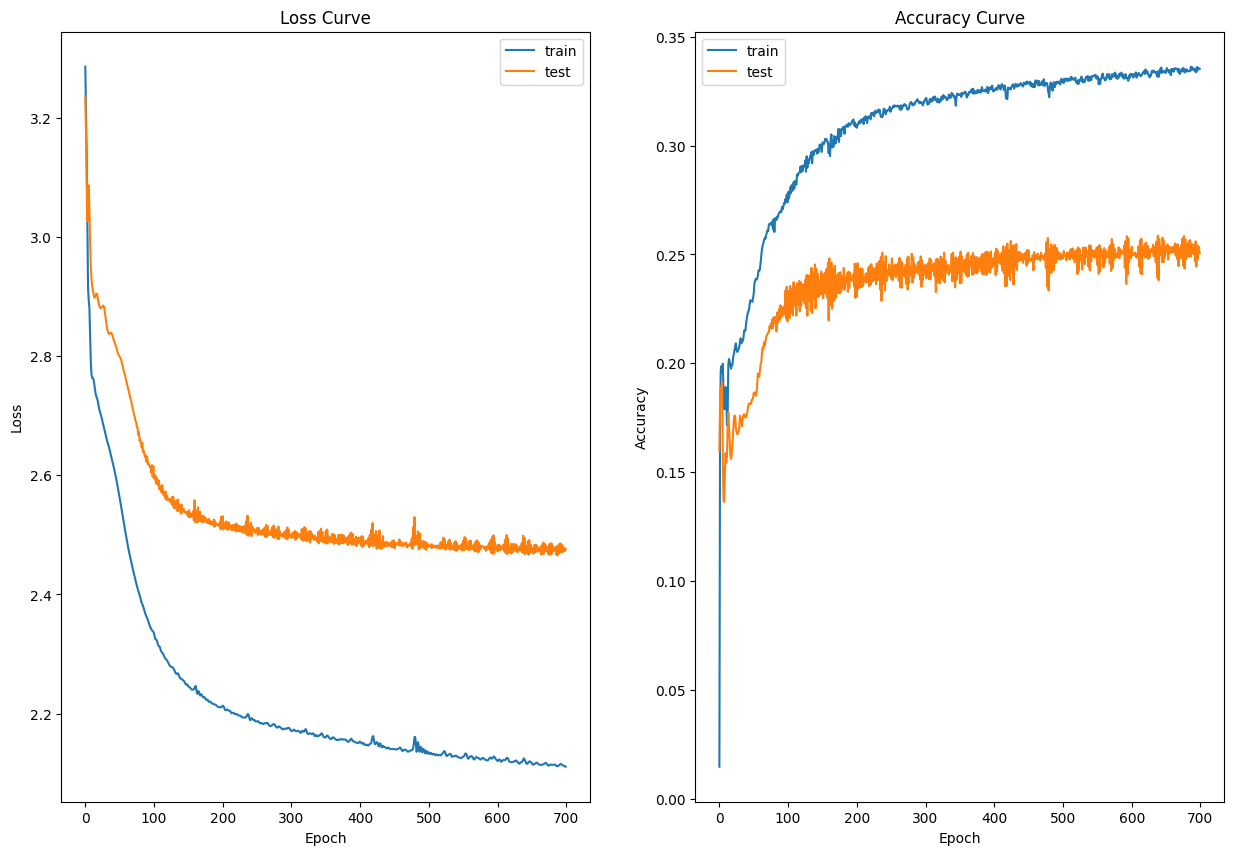

In [ ]:
# TODO: Train the model (0 marks - just use the same training code as before, but print out the losses every now and then)


## Functions to train and evaluate the model
def fit_one_epoch(model,
                  X, y,
                  optimizer, loss_fn):
    '''
    Perform one epoch of training
    '''
    # Set the model in train mode
    model.train()

    # TODO: Forward Pass (get the logits)
    logits = model(X)

    # TODO: Calculate the loss
    loss = loss_fn(logits, y)

    # TODO: Optimizer zero grad
    optimizer.zero_grad()

    # TODO: Backward pass
    loss.backward()

    # TODO: Step the optimizer
    optimizer.step()

    # Calculate the accuracy
    # Hint: Take the argmax of the logits along the last axis and compare with y
    acc = (logits.argmax(dim=1) == y).float().mean()

    return loss.item(), acc.item()

@torch.no_grad()
def evaluate(model,
             X, y,
             loss_fn):
    '''
    Perform one epoch of evaluation
    '''
    # Set the model in eval mode
    model.eval()

    # TODO: Forward Pass (get the logits)
    logits = model(X)

    # TODO: Calculate the loss
    loss = loss_fn(logits, y)

    # TODO: Calculate the accuracy
    acc = (logits.argmax(dim=1) == y).float().mean()

    return loss.item(), acc.item()

def fit(model,
        X_train, y_train, X_val, y_val,
        optimizer, loss_fn,
        epochs=200):
    '''
    Perform the entire training process
    '''
    # Create a history object to store the losses and accuracies
    history = {k: [] for k in ["train_loss", "train_acc", "val_loss", "val_acc"]}

    for epoch in range(epochs):
        # TODO: Training step
        train_loss, train_acc = fit_one_epoch(model, X_train, y_train, optimizer, loss_fn)

        # TODO: Evaluation step
        val_loss, val_acc = evaluate(model, X_val, y_val, loss_fn)

        # Optional logging
        # if epoch % (epochs//2) == 0 or epoch == epochs-1:
        print(f"Epoch {epoch} | Train loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

        # Save the losses and accuracies to the history object
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

    return history




X_train, X_test, y_train, y_test = X[0:159700], X[159700:], Y[0:159700], Y[159700:]
y_train = y_train.long()
y_test = y_test.long()
print("X_train:",X_train)
print("y_train:",y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)




# Create the loss function
loss_fn = nn.CrossEntropyLoss()
# Create the optimizer (use Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# Fit the model and plot the losses
history = fit(model, X_train, y_train, X_test, y_test, optimizer, loss_fn, epochs=700)
# Save the model
torch.save(model.state_dict(), 'names_classifier.pth')




# Plot the loss curves
plt.figure(figsize=(15, 10))

plt.subplot(121)
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss Curve")
plt.legend()

plt.subplot(122)
plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy Curve")
plt.legend()

plt.show()

## Generating Names [5 Marks]

Now that you've trained a model, and hopefully seen the loss go down, it's time to generate some names!

The algorithm is simple:
1. Start with an vector of zeros (the model knows this means the start of a name from the training process)

2. Feed this vector into the model to get a probability distribution over the next character

3. Sample a character from this distribution

4. Repeat steps 2 and 3 until you get a `[.]` character

In [10]:
num_names = 20

for i in range(num_names):

    # TODO: Create a vector of zeros for starters
    ctx = [0]*ctx_len
    gen_name = ''

    # Infinite loop till we get a . character
    while True:

        # TODO: Convert the context to a tensor
        ctx_tensor = torch.tensor(ctx).unsqueeze(0)

        # TODO: Pass the context through the model
        logits = model(ctx_tensor)

        # TODO: Get the probabilities by applying softmax
        probas = F.softmax(logits, dim=1)

        # TODO: Sample from the distribution to get the next character (use torch.multinomial)
        idx = torch.multinomial(probas, 1).item()

        # TODO: Convert the index to a character
        char = itos[idx]

        # Append the character to the generated name
        gen_name += char

        # TODO: Update the context
        ctx = ctx[1:]+[idx]

        # TODO: Break if we get a . character
        if(char=='.'):
            break
        # print(gen_name)

    # Print the generated name!
    print(gen_name)

dyxlie.
washawsyni.
shan.
nihiay.
ami.
yana.
jerizina.
dyn.
jamila.
paebr.
davi.
rud.
ayla.
adnah.
bairahe.
daalonia.
lin.
aumene.
amalysania.
kaysencha.


## Fin.